# <center>Analisando dados CAPNOBASE PPG - Respiração</center>

Os dados originais (https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/NLB8IT) foram adquiridos de 42 pacientes durante cirurgia eletiva e anestesia de rotina, com gravações de 8 minutos e cada uma contém:
<ul>
<li> Sinal PPG bruto para 42 casos de 8 min de duração; </li>
<li> pico de pulso e rótulos de artefatos validados por um avaliador especialista; </li>
<li> sinal de referência de CO2 e RR instantâneo derivado para todos os casos; </li>
<li> sinal de ECG de referência com rótulos de pico R e artefato, validado por um avaliador especialista;</li>
<li> referência de FC instantânea derivada de rótulos de pico de pulso de ECG e PPG;</li>
<li> saída do algoritmo SmartFusion e subcomponentes quando aplicado a este conjunto de dados de referência para comparação com seu algoritmo.</li>
</ul>

## Dados Formato MAT

Arquivos CSV separados são fornecidos para cada gravação (onde ## é o número do paciente), contendo:
<ul>
<li> param: taxas de amostragem e nome do caso, modo de ventilação; </li>
<li> meta: meta-informações como dados demográficos; </li>
<li> sinal: sinais brutos de co2 e pleth; </li>
<li> rótulos: rótulos para batimentos, respirações e artefatos obtidos de um avaliador humano;</li>
<li> referência: tendências derivadas a partir de rótulos; </li>
<li> SResultados: RR obtido usando a abordagem Smart Fusion e suas etapas. </li>
</ul>

In [57]:
%%time
import pandas as pd
import os
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import numpy  as np
import h5py

from scipy.fft import fft, fftfreq, ifft
from datetime import datetime
from plotly.subplots import make_subplots
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from openpyxl import load_workbook
from scipy.signal import butter, lfilter, freqz


#pasta para salvar os arquivos
os.chdir("C:\\Users\\ayalo\\PPG\\RESULTADOS\\CAPNOBASE" )

# Inicializa o modo Plotly Notebook 
py.init_notebook_mode(connected=False)

Wall time: 53.9 ms


In [58]:
#Data CAPNOBASE
#144001 amostras
num_arquivos = 40
fre_sinal = 300

#dados manipulaveis
frequencia = 300
inicio = 60
fim = 100
janela = 20

amostras1 = inicio * fre_sinal
amostras = fim * fre_sinal
N = amostras - amostras1

N_PPG = (480 * frequencia)
N_JANELA = janela * frequencia
N_JANELA_NORMAL = janela * fre_sinal
janela_tempo = fim - (inicio + janela) #quantidade de repetiçoes

In [59]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def manipulation_frequency(array):
    array = np.asarray(array)
    vetor = np.zeros(N_PPG)
    for i in range(N_PPG):
        vetor[i] = array[i*int(fre_sinal/frequencia)]
    return vetor 

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


In [60]:
%%time

#Cria Matriz Vazia
PPG_cap = np.empty((num_arquivos, N_PPG))
CO2_cap = np.empty((num_arquivos, 144000))
rpm_cap = np.empty((num_arquivos, 321))
rpms_cap = np.empty((num_arquivos, 321))

for i in range(num_arquivos):
    caminhoCAPNOBASE  = "C:\\Users\\ayalo\\PPG\\DADOS\\capnobase_mat\\8min ("+str(i+1)+").mat"
    f = h5py.File(caminhoCAPNOBASE,'r') 
    data = f.get('/signal/pleth/y')
    data = np.array(data)
    data = data[0][0:144000]
    PPG_cap[i] = manipulation_frequency(data)
    
    data = f.get('/signal/co2/y')
    data = np.array(data)
    CO2_cap[i] = data[0][0:144000]
        
    data = f.get('/reference/rr/co2/x')
    data = np.array(data).transpose()
    data = data[0]*300
    data = np.round(data,0)

    x = np.where(data == (find_nearest(data, amostras1)))
    x = x[0][0]
    y = np.where(data == (find_nearest(data, amostras)))
    y = y[0][0]

    rpms_cap[i] = 0
    rpms_cap[i][x:y] = data[x:y]
    


    data = f.get('/reference/rr/co2/y')
    data = np.array(data).transpose()
    data = data[0]
    
    rpm_cap[i] = 0
    rpm_cap[i][x:y] = data[x:y]
    
rpm_cap[np.isinf(rpm_cap)] = 0
rpm_cap[np.isnan(rpm_cap)] = 0

Wall time: 2.61 s


In [61]:
%%time
resultado33 = np.empty((num_arquivos,5*janela_tempo))
www = 0

for kk in range(janela_tempo):
    ######################################################################### FFT ##########################################################################################################################
    # sample spacing
    T = 1 / fre_sinal
    T_PPG = 1 / frequencia

    Xfft_PPG = np.empty((num_arquivos, int(N_JANELA/2)))
    Yfft_PPG = np.empty((num_arquivos, int(N_JANELA/2)))
    Xfft_CO2 = np.empty((num_arquivos, int(N_JANELA_NORMAL/2)))
    Yfft_CO2 = np.empty((num_arquivos, int(N_JANELA_NORMAL/2)))
    resultado = np.empty((num_arquivos,6))
    sinal_ppg = np.empty((num_arquivos,N_JANELA))

    FrPPG = np.array(range(num_arquivos))
    FrCO2 = np.array(range(num_arquivos))
    FrREF = np.array(range(num_arquivos))
    Erro_fft = np.array(range(num_arquivos))
    Erro_medido = np.array(range(num_arquivos))

    Y = np.linspace(1, 42, num_arquivos)
    for i in range(num_arquivos):
        
        cp1 = (kk * frequencia) + (frequencia * inicio) 
        cp2 = N_JANELA + cp1
        
        #################################################################################fft
        y0 = PPG_cap[i][cp1:cp2]
        #################################################################################fft
        
        
        
        
#         #################################################################################linha de base/amplitude/frequencia      
#         #sinal original com aumento das extremidades e remoção do sinal DC por media
#         sinal_original = PPG_cap[i][cp1-2000:cp2+2000]
#         sinal_ac = sinal_original - np.mean(sinal_original)
#         #pegando os picos e vales
#         val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
#         vales_x, _ = find_peaks((sinal_ac*(-1)), prominence=1)
#         #Diferença no numero de vales e picos é menor q 2
#         if( abs(len(val_x_peaks_ac) - len(vales_x)) < 3):
            
# #             ###############################AMPLITUDE    
# #             #quantidade de picos menores/igual e primeiro pico começa antes do vale
# #             if( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
# #                 pedro = np.zeros(len(val_x_peaks_ac)-1)
# #                 for z in range(len(pedro)-1):
# #                     pedro[z] = sinal_ac[val_x_peaks_ac[z+1]] - sinal_ac[vales_x[z]]
                
# #             #quantidade de picos menores/igual e primeiro pico começa depois do vale
# #             elif( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
# #                 pedro = np.zeros(len(val_x_peaks_ac))
# #                 for z in range(len(pedro)):
# #                     pedro[z] = sinal_ac[val_x_peaks_ac[z]] - sinal_ac[vales_x[z]]

# #             #quantidade de vales menores/igual e primeiro pico começa antes do vale
# #             elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
# #                 pedro = np.zeros(len(vales_x)-1)
# #                 for z in range(len(pedro)-1):
# #                     pedro[z] = sinal_ac[val_x_peaks_ac[z+1]] - sinal_ac[vales_x[z]]

# #             #quantidade de vales menores/igual e primeiro pico começa depois do vale
# #             elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
# #                 pedro = np.zeros(len(vales_x))
# #                 for z in range(len(pedro)):
# #                     pedro[z] = sinal_ac[val_x_peaks_ac[z]] - sinal_ac[vales_x[z]]

# #             else:
# #                 www = www + 1
# #                 print("condiçao maluca ver", inicio, fim, www)


# #             s_a = interp1d(vales_x[0:len(pedro)], pedro, kind = 'linear',bounds_error = False, fill_value=0.0)
# #             maria = np.zeros(len(sinal_original))
# #             for aux3 in range(len(sinal_original)):
# #                 maria[aux3] = s_a(aux3)    
# #             y0 = maria[2000:(len(sinal_original)-2000)]
# #             ###############################AMPLITUDE
            
#             # ###############################LINHA DE BASE            
#             # l_b = interp1d(val_x_peaks_ac,sinal_original[val_x_peaks_ac], kind = 'linear',bounds_error = False, fill_value=0.0)
#             # pedro = np.zeros(len(sinal_original))
#             # for k in range(len(sinal_original)):
#             #     pedro[k] = l_b(k)
#             # y0 = pedro[2000:(len(sinal_original)-2000)]
#             # ###############################LINHA DE BASE
            
#             ###############################FREQUENCIA
#             fm_y = np.zeros(len(val_x_peaks_ac)-1)
#             for z in range(len(val_x_peaks_ac)-1):
#                 fm_y[z] = val_x_peaks_ac[z+1]-val_x_peaks_ac[z]
#             fm_x = val_x_peaks_ac[0:(len(val_x_peaks_ac)-1)]
#             s_f = interp1d(fm_x,fm_y, kind = 'linear',bounds_error = False, fill_value=0.0)
#             joao = np.zeros(len(sinal_original))
#             for k in range(len(sinal_original)):
#                 joao[k] = s_f(k)
#             y0 = joao[2000:(len(sinal_original)-2000)]
#             ###############################FREQUENCIA            
            
#         else:
#             www = www + 1
#             print("picos e vales diferentes de 1!", cp1, cp2, www, i)
#             tt = np.linspace(0, janela, N_JANELA, endpoint=False)
#             y0 = np.sin(0.83*2*np.pi*tt)
        
#         #############EMD
#         order = 5       
#         cutoff = 2
#         data = PPG_cap[i][cp1:cp2]
#         #ROGERIN = butter_lowpass_filter(data, cutoff, frequencia, order)
#         time = np.linspace(0, 1, len(data))
#         emd1 = EMD()
#         IMF = emd1.emd(data, time)

#         #y0 = IMF[0] #IMF1
#         #y0 = IMF[1] #IMF2
#         #y0 = IMF[2] #IMF3
#         #y0 = IMF[3] #IMF4
#         #############EMD
        
        
        sinal_ppg[i] = y0
        yf0 = fft(y0)
        xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
        yf0 = np.abs(yf0[0:N_JANELA//2])
        Xfft_PPG[i] = xf0
        Yfft_PPG[i] = yf0

        cp3 = (kk * fre_sinal) + (fre_sinal * inicio)
        cp4 = N_JANELA_NORMAL + cp3
        y1 = CO2_cap[i][cp3:cp4]
        yf1 = fft(y1)
        x1 = fftfreq(N_JANELA_NORMAL, T)[:N_JANELA_NORMAL//2]
        y1 = np.abs(yf1[0:N_JANELA_NORMAL//2])
        Xfft_CO2[i] = x1
        Yfft_CO2[i] = y1

        fyy = Xfft_PPG[i][5] - Xfft_PPG[i][4]
        p1 = int(0.15/fyy)
        p2 = int(0.83/fyy)
        
        fy = Xfft_CO2[i][5] - Xfft_CO2[i][4]
        p3 = int(0.15/fy)
        p4 = int(0.83/fy)     

        pos_y = Yfft_PPG[i][p1:p2].argmax()
        val_x = Xfft_PPG[i][pos_y+p1]
        FrPPG[i] = val_x*60

        pos_y = Yfft_CO2[i][p3:p4].argmax()
        val_x = Xfft_CO2[i][pos_y+p3]
        FrCO2[i] = val_x*60

        data = np.where(rpm_cap[i] != (find_nearest(rpm_cap[i], 0)))
        y = data[0].size    
        y = y - 1

        y = data[0][y]
        x = data[0][0]
        FrREF[i] = np.mean(rpm_cap[i][x:y])

        Erro_fft[i] = FrCO2[i] - FrPPG[i]

        Erro_medido[i] = FrREF[i] - FrPPG[i]
        Y[i] = i + 1
        resultado[i] = [ Y[i], FrPPG[i], FrCO2[i], FrREF[i], Erro_fft[i], Erro_medido[i] ] 
    print(cp1,cp2)
    print(cp3,cp4)
    ########################################################################## Calcula raiz do erro medio quadradico ###########################################################################################

    resultado1 = np.empty((5,2))

    RMSE_fftCO2 = rmse(FrPPG, FrCO2)
    RMSE_FrREF = rmse(FrPPG, FrREF)

    percentual0_fftCO2 = ((np.count_nonzero((Erro_fft==0)))*100)/Erro_fft.size
    percentual1_fftCO2 = ((np.count_nonzero((Erro_fft<1)&(Erro_fft>-1)))*100)/Erro_fft.size
    percentual2_fftCO2 = ((np.count_nonzero((Erro_fft<2)&(Erro_fft>-2)))*100)/Erro_fft.size
    percentual3_fftCO2 = ((np.count_nonzero((Erro_fft<3)&(Erro_fft>-3)))*100)/Erro_fft.size

    percentual0_FrREF = (np.count_nonzero((Erro_medido==0))*100)/Erro_medido.size
    percentual1_FrREF = ((np.count_nonzero((Erro_medido<1)&(Erro_medido>-1)))*100)/Erro_medido.size
    percentual2_FrREF = ((np.count_nonzero((Erro_medido<2)&(Erro_medido>-2)))*100)/Erro_medido.size
    percentual3_FrREF = ((np.count_nonzero((Erro_medido<3)&(Erro_medido>-3)))*100)/Erro_medido.size

    resultado1[0] = [round(RMSE_fftCO2,1),round(RMSE_FrREF,1)]
    resultado1[1] = [round(percentual0_fftCO2,1),round(percentual0_FrREF,1)]
    resultado1[2] = [round(percentual1_fftCO2,1),round(percentual1_FrREF,1)]
    resultado1[3] = [round(percentual2_fftCO2,1),round(percentual2_FrREF,1)]
    resultado1[4] = [round(percentual3_fftCO2,1),round(percentual3_FrREF,1)]

    ###################################################################################### plot ################################################################################################################

    linhas = 5

    # Create figure
    fig = make_subplots(rows=linhas, cols=1)
    # Add all traces of pacient
    for i in range(num_arquivos):
        fig.add_scatter(y=sinal_ppg[i],
                        row=1, col=1, visible=False,
                        showlegend = False,
                        name = "(x,y)",
                        marker_color="red")
    for i in range(num_arquivos):
        fig.add_scatter(y=CO2_cap[i][cp3:cp4],
                        row=2, col=1, visible=False,
                        showlegend = False,
                        name = "(x,y)",
                        marker_color="black")
    for i in range(num_arquivos):
        fig.add_scatter(x=rpms_cap[i], y=rpm_cap[i],
                        row=3, col=1, visible=False,
                        showlegend = False,
                         mode="markers",
                        name = "(x,y)",
                        marker_color="green")
    for i in range(num_arquivos):
        Y=Yfft_PPG[i] * 2/N_JANELA
        fig.add_scatter(x=Xfft_PPG[i][p1:p2], y=Y[p1:p2],
                        row=4, col=1, visible=False,
                        showlegend = False,
                        name = "(x,y)",
                        marker_color="red")
    for i in range(num_arquivos):
        Y=Yfft_CO2[i] * 2/N_JANELA_NORMAL
        fig.add_scatter(x=Xfft_CO2[i][p3:p4] , y=Y[p3:p4],
                        row=5, col=1, visible=False,
                        showlegend = False,
                        name = "(x,y)",
                        marker_color="black")

    # Make 10th trace visible
    for i in range(linhas):
        fig.data[i*num_arquivos].visible = True


    # Create and add slider
    steps = []
    for i in range(num_arquivos):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)}],  # layout attribute
        )
        for k in range(linhas):
            step["args"][0]["visible"][i+(k*num_arquivos)] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        steps=steps
    )]

    # Update xaxis properties
    fig.update_xaxes(title_text="Amostras (u)", row=2, col=1)
    fig.update_xaxes(title_text="Tempo (s)", row=3, col=1)
    fig.update_xaxes(title_text="frequencia (Hz)", row=5, col=1)
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    # Update yaxis properties
    fig.update_yaxes(title_text="PPG", row=1, col=1)
    fig.update_yaxes(title_text="CO2", row=2, col=1)
    fig.update_yaxes(range = [1,50],title_text="rpm", row=3, col=1)
    fig.update_yaxes(title_text="FFT-PPG", row=4, col=1)
    fig.update_yaxes(title_text="FFT-CO2", row=5, col=1)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    fig.update_layout(
        title="Capnobase Sinal:",
        sliders=sliders,
        plot_bgcolor='rgba(0,0,0,0)',
        height=1000
    )

    # Edit slider labels
    fig['layout']['sliders'][0]['currentvalue']['prefix']='Paciente: '
    for i in range(num_arquivos):
        fig['layout']['sliders'][0]['steps'][i]['label']=i+1


    #fig.show()
    plotly.offline.plot(fig, filename="De"+str(inicio+kk)+"ate"+str(inicio+janela+kk)+'.html',auto_open=False)


    ######################################################################################## salva excel #######################################################################################################

#     data_array = resultado[:,1:]
#     row_indices = resultado[:,0]
#     column_names = ['PPG','CO2', 'RR', 'CO2-PPG', 'RR-PPG']


#     data_df = pd.DataFrame(data_array, columns=column_names, index=row_indices)

#     book = load_workbook('erro.xlsx')
#     writer = pd.ExcelWriter('erro.xlsx', engine = 'openpyxl', mode='a')
#     writer.book = book
#     data_df.to_excel(writer, sheet_name="De"+str(inicio+kk)+"ate"+str(inicio+janela+kk))
#     writer.close()

    data_array = resultado1
    row_indices = ['RMSE','PERCENTUAL-0rpm','PERCENTUAL-1rpm','PERCENTUAL-2rpm','PERCENTUAL-3rpm']
    column_names = ['CO2-PPG', 'RR-PPG']


    data_df = pd.DataFrame(data_array, columns=column_names, index=row_indices)

    book = load_workbook('precisao.xlsx')
    writer = pd.ExcelWriter('precisao.xlsx', engine = 'openpyxl', mode='a')
    writer.book = book
    data_df.to_excel(writer, sheet_name="De"+str(inicio+kk)+"ate"+str(inicio+janela+kk))
    writer.close()
    
    resultado33[0:,(kk*5):(5+(kk*5))] = resultado[:,1:]
    
    print(kk)
    
data_array = resultado33
row_indices = resultado[:,0]
data_df = pd.DataFrame(data_array, index=row_indices)

book = load_workbook('erro.xlsx')
writer = pd.ExcelWriter('erro.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
data_df.to_excel(writer, sheet_name="TUDO")
writer.close()

18000 24000
18000 24000
0
18300 24300
18300 24300
1
18600 24600
18600 24600
2
18900 24900
18900 24900
3
19200 25200
19200 25200
4
19500 25500
19500 25500
5
19800 25800
19800 25800
6
20100 26100
20100 26100
7
20400 26400
20400 26400
8
20700 26700
20700 26700
9
21000 27000
21000 27000
10
21300 27300
21300 27300
11
21600 27600
21600 27600
12
21900 27900
21900 27900
13
22200 28200
22200 28200
14
22500 28500
22500 28500
15
22800 28800
22800 28800
16
23100 29100
23100 29100
17
23400 29400
23400 29400
18
23700 29700
23700 29700
19
Wall time: 16 s


In [ ]:
%%time

linhas = 5

# Create figure
fig = make_subplots(rows=linhas, cols=1)
# Add all traces of pacient
for i in range(num_arquivos):
    fig.add_scatter(y=PPG_cap[i][0:amostras],
                    row=1, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="red")
for i in range(num_arquivos):
    fig.add_scatter(y=CO2_cap[i][0:amostras],
                    row=2, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="black")
for i in range(num_arquivos):
    fig.add_scatter(x=rpms_cap[i], y=rpm_cap[i],
                    row=3, col=1, visible=False,
                    showlegend = False,
                     mode="markers",
                    name = "(x,y)",
                    marker_color="green")
for i in range(num_arquivos):
    Y=Yfft_PPG[i] * 2/N
    fig.add_scatter(x=Xfft_PPG[i][p1:p2], y=Y[p1:p2],
                    row=4, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="red")
for i in range(num_arquivos):
    Y=Yfft_CO2[i] * 2/N
    fig.add_scatter(x=Xfft_CO2[i][p1:p2] , y=Y[p1:p2],
                    row=5, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="black")

# Make 10th trace visible
for i in range(linhas):
    fig.data[i*num_arquivos].visible = True


# Create and add slider
steps = []
for i in range(num_arquivos):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # layout attribute
    )
    for k in range(linhas):
        step["args"][0]["visible"][i+(k*num_arquivos)] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    steps=steps
)]

# Update xaxis properties
fig.update_xaxes(title_text="Amostras (u)", row=2, col=1)
fig.update_xaxes(title_text="frequencia (Hz)", row=4, col=1)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

# Update yaxis properties
fig.update_yaxes(title_text="PPG", row=1, col=1)
fig.update_yaxes(title_text="CO2", row=2, col=1)
fig.update_yaxes(range = [1,50],title_text="FFT-PPG", row=3, col=1)
fig.update_yaxes(title_text="FFT-CO2", row=4, col=1)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.update_layout(
    title="Capnobase Sinal:",
    sliders=sliders,
    plot_bgcolor='rgba(0,0,0,0)',
    height=1000
)

# Edit slider labels
fig['layout']['sliders'][0]['currentvalue']['prefix']='Paciente: '
for i in range(num_arquivos):
    fig['layout']['sliders'][0]['steps'][i]['label']=i+1


#fig.show()
plotly.offline.plot(fig, filename="De"+str(inicio)+"ate"+str(fim)+'.html',auto_open=False)
print(len(fig.data))
####################### TABLE ##############################

#Y = np.linspace(1, num_arquivos, num_arquivos)
#fig = go.Figure(data=[go.Table(header=dict(values=['Paciente','PPG','CO2', 'RR', 'CO2-PPG', 'RR-PPG'],fill_color='LightGrey', align='center'),
#                               cells=dict(values=[Y, FrPPG, FrCO2, FrREF, Erro_fft, Erro_medido],  fill_color = ['LightGrey','white', 'white']))
#                                ])
    
#fig.update_layout(
#    plot_bgcolor='rgba(0,0,0,0)',
#    height=1100
#)
#fig.show()
####################### TABLE 2#############################

#Y = np.linspace(1, 42, num_arquivos)
#fig = go.Figure(data=[go.Table(header=dict(values=['', 'CO2-PPG', 'RR-PPG'],fill_color='LightGrey', align='center'),
#                               cells=dict(values=[['RMSE','PERCENTUAL-0rpm','PERCENTUAL-1rpm','PERCENTUAL-2rpm','PERCENTUAL-3rpm'], [RMSE_fftCO2, percentual0_fftCO2, percentual1_fftCO2, percentual2_fftCO2, percentual3_fftCO2], [RMSE_FrREF, percentual0_FrREF, percentual1_FrREF, percentual2_FrREF, percentual3_FrREF]],  fill_color = ['LightGrey','white', 'white']))
#                                ])
    
#fig.update_layout(
#    plot_bgcolor='rgba(0,0,0,0)',
#    height=100
#)
#fig.show()

In [ ]:
data_array = resultado[:,1:]
row_indices = resultado[:,0]
column_names = ['PPG','CO2', 'RR', 'CO2-PPG', 'RR-PPG']


data_df = pd.DataFrame(data_array, columns=column_names, index=row_indices)

book = load_workbook('erro.xlsx')
writer = pd.ExcelWriter('erro.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
data_df.to_excel(writer, sheet_name="De"+str(inicio)+"ate"+str(fim))
writer.close()

data_array = resultado1
row_indices = ['RMSE','PERCENTUAL-0rpm','PERCENTUAL-1rpm','PERCENTUAL-2rpm','PERCENTUAL-3rpm']
column_names = ['CO2-PPG', 'RR-PPG']


data_df = pd.DataFrame(data_array, columns=column_names, index=row_indices)

book = load_workbook('precisao.xlsx')
writer = pd.ExcelWriter('precisao.xlsx', engine = 'openpyxl', mode='a')
writer.book = book
data_df.to_excel(writer, sheet_name="De"+str(inicio)+"ate"+str(fim))
writer.close()

    

In [ ]:
%%time
#variavel
linha_base = np.empty((num_arquivos, N_JANELA))
amplitude = np.empty((num_arquivos, N_JANELA))
frequenciaM = np.empty((num_arquivos, N_JANELA))
Xfft_am = np.empty((num_arquivos, int(N_JANELA/2)))
Yfft_am = np.empty((num_arquivos, int(N_JANELA/2)))
Xfft_fm = np.empty((num_arquivos, int(N_JANELA/2)))
Yfft_fm = np.empty((num_arquivos, int(N_JANELA/2)))
Xfft_bl = np.empty((num_arquivos, int(N_JANELA/2)))
Yfft_bl = np.empty((num_arquivos, int(N_JANELA/2)))


for i in range(num_arquivos):

    sinal_original = PPG_cap[i][0:6000]
    T_PPG = 1 / frequencia

    #pico e vale
    val_x_peaks, _ = find_peaks(sinal_original, prominence=1)
    vales_x, _ = find_peaks((sinal_original*(-1)), prominence=1)

    #linha de base
    l_b = interp1d(val_x_peaks,sinal_original[val_x_peaks], kind = 'linear',bounds_error = False, fill_value=0.0)
    print(val_x_peaks[0])
    for k in range(0,len(sinal_original)):
        linha_base[i][k] = l_b(k)  

    yf0 = fft(linha_base[i])
    xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
    yf0 = np.abs(yf0[0:N_JANELA//2])
    Xfft_bl[i] = xf0
    Yfft_bl[i] = yf0


    #amplitude
    sinal_ac = sinal_original - np.mean(sinal_original)
    val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
    s_a = interp1d(val_x_peaks_ac,sinal_ac[val_x_peaks_ac], kind = 'linear',bounds_error = False, fill_value=0.0)
    for k in range(0,len(sinal_ac)):
        amplitude[i][k] = s_a(k)

    yf1 = fft(amplitude[i])
    xf1 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
    yf1 = np.abs(yf1[0:N_JANELA//2])
    Xfft_am[i] = xf1
    Yfft_am[i] = yf1


    #frequencia
    fm_y = np.zeros(len(val_x_peaks)-1)
    for z in range(len(val_x_peaks)-1):
        fm_y[z] = val_x_peaks[z+1]-val_x_peaks[z]
    fm_x = val_x_peaks[0:(len(val_x_peaks)-1)]

    s_f = interp1d(fm_x,fm_y, kind = 'linear',bounds_error = False, fill_value=0.0)
    for k in range(0,len(sinal_ac)):
        frequenciaM[i][k] = s_f(k)

    yf2 = fft(frequenciaM[i])
    xf2 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
    yf2 = np.abs(yf2[0:N_JANELA//2])
    Xfft_fm[i] = xf2
    Yfft_fm[i] = yf2

    fy = Xfft_fm[i][5] - Xfft_fm[i][4]
    p3 = int(0.15/fy)
    p4 = int(0.83/fy)

In [ ]:
linhas = 7

# Create figure
fig = make_subplots(rows=linhas, cols=1)
# Add all traces of pacient
for i in range(num_arquivos):
    fig.add_scatter(y=PPG_cap[i][0:6000],
                    row=1, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="red")
for i in range(num_arquivos):
    fig.add_scatter(y=linha_base[i],
                    row=2, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="black")
for i in range(num_arquivos):
    fig.add_scatter(y=amplitude[i],
                    row=3, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="green")
for i in range(num_arquivos):
    fig.add_scatter(y=frequenciaM[i],
                    row=4, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="green")
for i in range(num_arquivos):
    Y=Yfft_bl[i] * 2/N
    fig.add_scatter(x=Xfft_bl[i][p3:p4], y=Y[p3:p4],
                    row=5, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="red")
for i in range(num_arquivos):
    Y=Yfft_am[i] * 2/N
    fig.add_scatter(x=Xfft_am[i][p3:p4] , y=Y[p3:p4],
                    row=6, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="black")
for i in range(num_arquivos):
    Y=Yfft_fm[i] * 2/N
    fig.add_scatter(x=Xfft_fm[i][p3:p4] , y=Y[p3:p4],
                    row=7, col=1, visible=False,
                    showlegend = False,
                    name = "(x,y)",
                    marker_color="black")

# Make 10th trace visible
for i in range(linhas):
    fig.data[i*num_arquivos].visible = True


# Create and add slider
steps = []
for i in range(num_arquivos):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # layout attribute
    )
    for k in range(linhas):
        step["args"][0]["visible"][i+(k*num_arquivos)] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    steps=steps
)]

# Update xaxis properties
fig.update_xaxes(title_text="Amostras (u)", row=2, col=1)
fig.update_xaxes(title_text="frequencia (Hz)", row=4, col=1)
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

# Update yaxis properties
fig.update_yaxes(title_text="PPG", row=1, col=1)
fig.update_yaxes(title_text="CO2", row=2, col=1)
fig.update_yaxes(title_text="FFT-PPG", row=3, col=1)
fig.update_yaxes(title_text="FFT-CO2", row=4, col=1)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.update_layout(
    title="Capnobase Sinal:",
    sliders=sliders,
    plot_bgcolor='rgba(0,0,0,0)',
    height=1000
)

# Edit slider labels
fig['layout']['sliders'][0]['currentvalue']['prefix']='Paciente: '
for i in range(num_arquivos):
    fig['layout']['sliders'][0]['steps'][i]['label']=i+1


fig.show()

## FIM

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
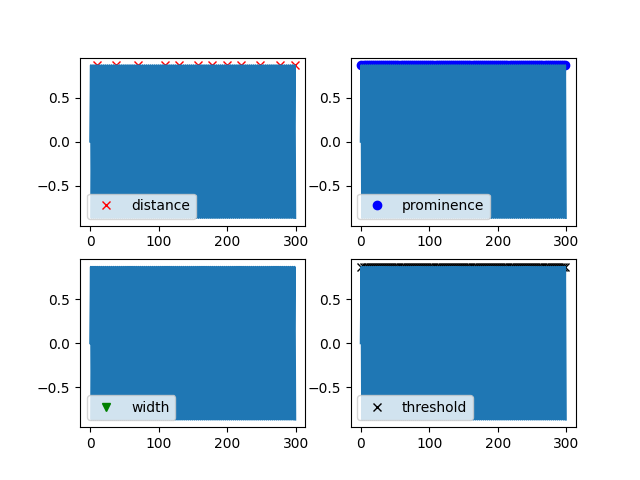

In [46]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

xx = np.sin(1000*2*np.pi*t)

peaks, _ = find_peaks(xx, distance=20)
peaks2, _ = find_peaks(xx, prominence=0.4)      # BEST!
peaks3, _ = find_peaks(xx, width=20)
peaks4, _ = find_peaks(xx, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
plt.subplot(2, 2, 1)
plt.plot(peaks, xx[peaks], "xr"); plt.plot(xx); plt.legend(['distance'])
plt.subplot(2, 2, 2)
plt.plot(peaks2, xx[peaks2], "ob"); plt.plot(xx); plt.legend(['prominence'])
plt.subplot(2, 2, 3)
plt.plot(peaks3, xx[peaks3], "vg"); plt.plot(xx); plt.legend(['width'])
plt.subplot(2, 2, 4)
plt.plot(peaks4, xx[peaks4], "xk"); plt.plot(xx); plt.legend(['threshold'])
plt.show()

In [12]:
%%time
%matplotlib widget
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

N = 6000

#variavel
linha_base = np.zeros(N)
amplitude = np.zeros(N)
frequencia = np.zeros(N)
Xfft_am = np.zeros(int(N/2))
Yfft_am = np.zeros(int(N/2))
Xfft_fm = np.zeros(int(N/2))
Yfft_fm = np.zeros(int(N/2))
Xfft_bl = np.zeros(int(N/2))
Yfft_bl = np.zeros(int(N/2))



T = 1/300
sinal_original = PPG_cap[6][17100:24900]

#pico e vale
val_x_peaks, _ = find_peaks(sinal_original, prominence=1)
vales_x, _ = find_peaks((sinal_original*(-1)), prominence=1)

#linha de base
l_b = interp1d(val_x_peaks,sinal_original[val_x_peaks], kind = 'linear',bounds_error = False, fill_value=0.0)
pedro = np.zeros(len(sinal_original))
for k in range(len(sinal_original)):
    pedro[k] = l_b(k)

linha_base = pedro[900:6900]

yf0 = fft(linha_base)
xf0 = fftfreq(N, T)[:N//2]
yf0 = np.abs(yf0[0:N//2])
Xfft_bl = xf0
Yfft_bl = yf0

#amplitude
sinal_ac = sinal_original - np.mean(sinal_original)
val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
s_a = interp1d(val_x_peaks_ac,sinal_ac[val_x_peaks_ac], kind = 'linear',bounds_error = False, fill_value=0.0)
maria = np.zeros(len(sinal_original))
for k in range(len(sinal_original)):
    maria[k] = s_a(k)
    
amplitude = maria[900:6900]
    
yf1 = fft(amplitude)
xf1 = fftfreq(N, T)[:N//2]
yf1 = np.abs(yf1[0:N//2])
Xfft_am = xf1
Yfft_am = yf1


#frequencia
fm_y = np.zeros(len(val_x_peaks)-1)
for z in range(len(val_x_peaks)-1):
    fm_y[z] = val_x_peaks[z+1]-val_x_peaks[z]
fm_x = val_x_peaks[0:(len(val_x_peaks)-1)]
s_f = interp1d(fm_x,fm_y, kind = 'linear',bounds_error = False, fill_value=0.0)
joao = np.zeros(len(sinal_original))
for k in range(len(sinal_original)):
    joao[k] = s_f(k)

frequencia = joao[900:6900]
    
yf2 = fft(frequencia)
xf2 = fftfreq(N, T)[:N//2]
yf2 = np.abs(yf2[0:N//2])
Xfft_fm = xf2
Yfft_fm = yf2

fy = Xfft_fm[5] - Xfft_fm[4]
p3 = int(0.15/fy)
p4 = int(0.83/fy)


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

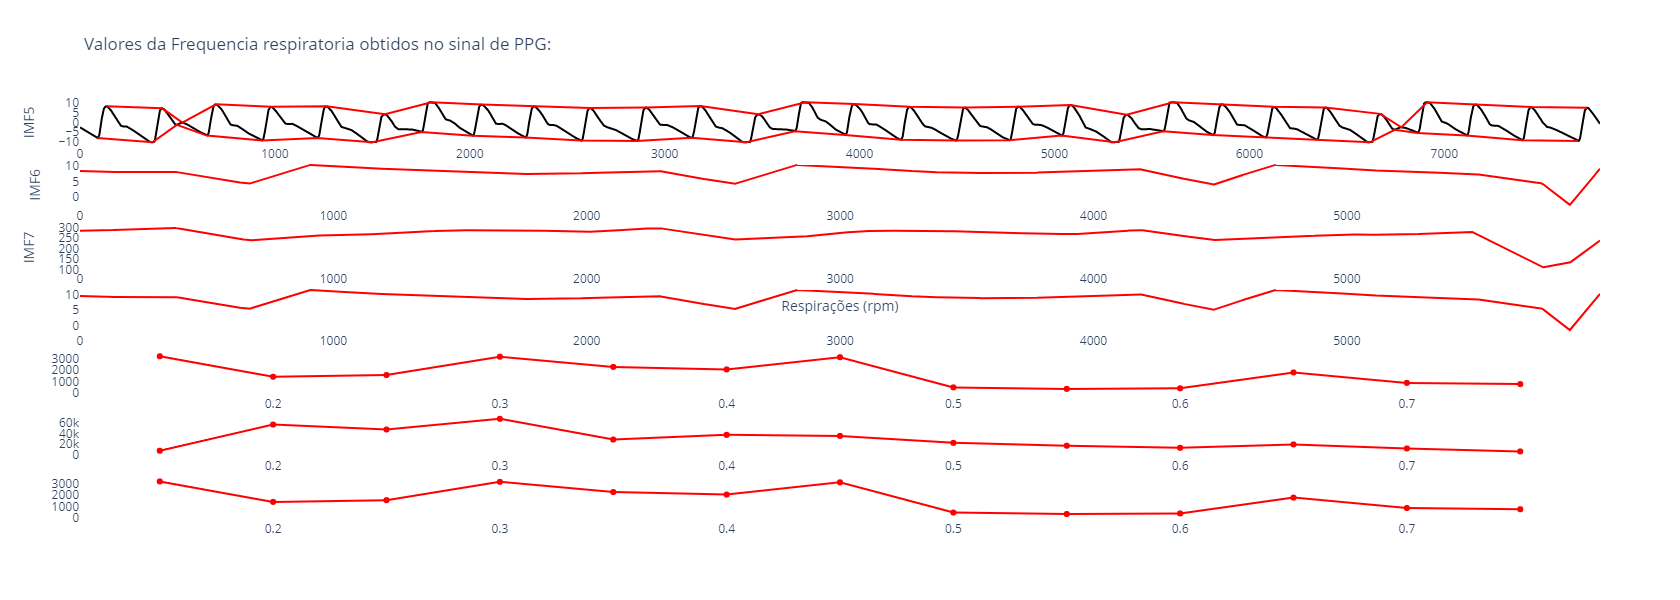

In [307]:
# Create figure
fig = make_subplots(rows=7, cols=1)

yy = np.linspace(1, 14400, 14400)
    

fig.add_scatter(y=sinal_original, name = "(x,y)", marker_color="black",row=1, col=1, showlegend = False)
fig.add_scatter(x=val_x_peaks, y=sinal_original[val_x_peaks], name = "(x,y)", row=1, col=1,marker_color="red", showlegend = False)
fig.add_scatter(x=vales_x, y=sinal_original[vales_x], name = "(x,y)", row=1, col=1,marker_color="red", showlegend = False)

fig.add_scatter(y=linha_base, name = "(x,y)", row=2, col=1,marker_color="red", showlegend = False)

fig.add_scatter(y=frequencia, name = "(x,y)", row=3, col=1,marker_color="red", showlegend = False)

fig.add_scatter(y=amplitude, name = "(x,y)", row=4, col=1,marker_color="red", showlegend = False)

fig.add_scatter(x=Xfft_bl[p3:p4] ,y=Yfft_bl[p3:p4] , name = "(x,y)", row=5, col=1,marker_color="red", showlegend = False)

fig.add_scatter(x=Xfft_fm[p3:p4] ,y=Yfft_fm[p3:p4] , name = "(x,y)", row=6, col=1,marker_color="red", showlegend = False)

fig.add_scatter(x=Xfft_am[p3:p4] ,y=Yfft_am[p3:p4] , name = "(x,y)", row=7, col=1,marker_color="red", showlegend = False)

# Make 10th trace visible
fig.data[0].visible = True

# Update xaxis properties
fig.update_xaxes(title_text="Respirações (rpm)", row=3, col=1)


# Update yaxis properties
fig.update_yaxes(title_text="IMF5", row=1, col=1)
fig.update_yaxes(title_text="IMF6", row=2, col=1)
fig.update_yaxes(title_text="IMF7", row=3, col=1)


fig.update_layout(
    title="Valores da Frequencia respiratoria obtidos no sinal de PPG:",
    plot_bgcolor='rgba(0,0,0,0)',
    height=600
)

fig.show()

In [ ]:
# EMD 

In [308]:
def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [34]:
%%time
%matplotlib widget

from PyEMD import EMD

N = 6000

#variavel

Xfft_IMF1 = np.zeros(int(N/2))
Yfft_IMF1 = np.zeros(int(N/2))
Xfft_IMF2 = np.zeros(int(N/2))
Yfft_IMF2 = np.zeros(int(N/2))
Xfft_IMF3 = np.zeros(int(N/2))
Yfft_IMF3 = np.zeros(int(N/2))



T = 1/300

order = 6
fs = 300.0       
cutoff = 2
data = PPG_cap[15][0:6000]
ROGERIN = butter_lowpass_filter(data, cutoff, fs, order)

signals = ROGERIN 
time = np.linspace(0, 1, N)

        # Assign max IMF on signal
emd1 = EMD()
        #emd1 = EMD(MAX_ITERATION = 10)

        # Execute EMD on signal
        #IMF = emd1.emd(Signal_PPG,time, max_imf = 3)
IMF = emd1.emd(ROGERIN,time)

print(len(IMF))

IMF1_IMP = IMF[0]
IMF2_IMP = IMF[1]
IMF3_IMP = IMF[2]
IMF4_IMP = IMF[3]
IMF5_IMP = IMF[4]






yf0 = fft(IMF1_IMP)
xf0 = fftfreq(N, T)[:N//2]
yf0 = np.abs(yf0[0:N//2])
Xfft_IMF1 = xf0
Yfft_IMF1 = yf0

yf1 = fft(IMF2_IMP)
xf1 = fftfreq(N, T)[:N//2]
yf1 = np.abs(yf1[0:N//2])
Xfft_IMF2 = xf1
Yfft_IMF2 = yf1

yf2 = fft(IMF3_IMP)
xf2 = fftfreq(N, T)[:N//2]
yf2 = np.abs(yf2[0:N//2])
Xfft_IMF3 = xf2
Yfft_IMF3 = yf2

fy = Xfft_IMF1[5] - Xfft_IMF1[4]
p3 = int(0.15/fy)
p4 = int(0.83/fy)

NameError: name 'butter_lowpass' is not defined

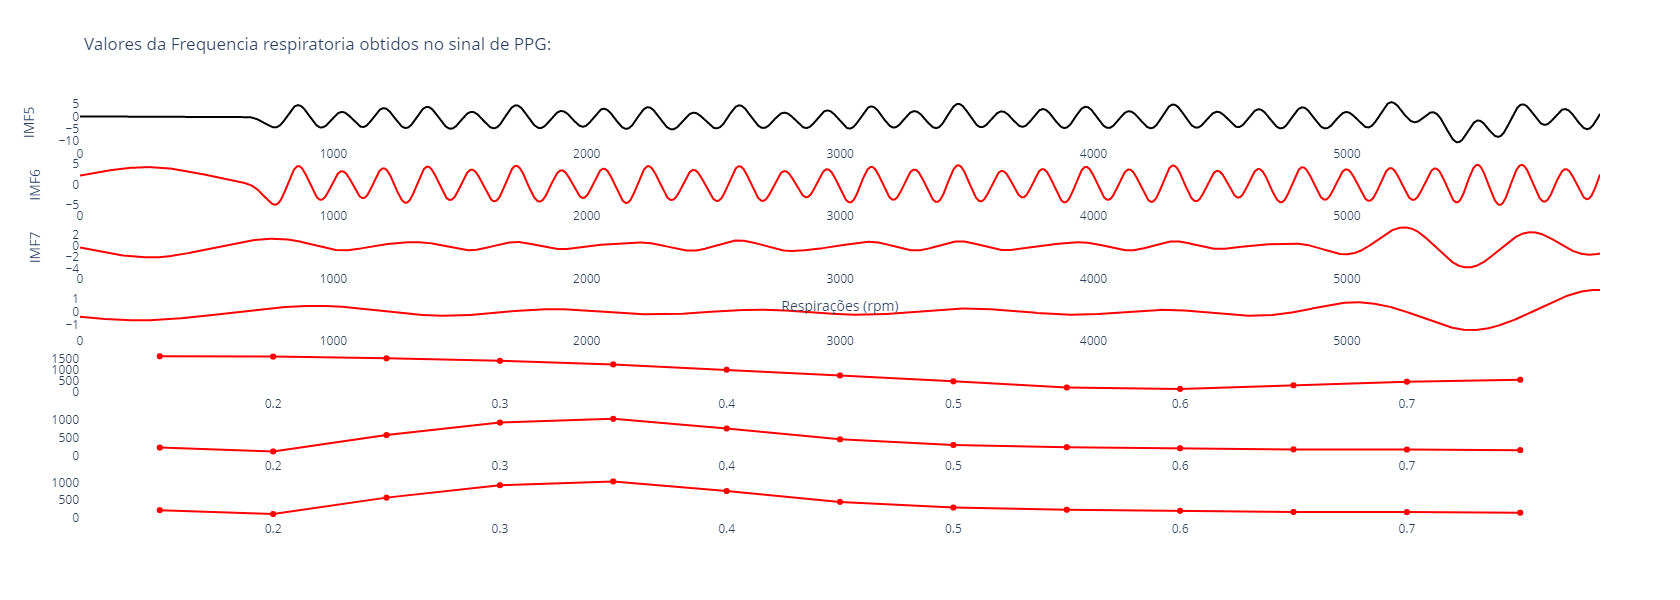

In [312]:
# Create figure
fig = make_subplots(rows=7, cols=1)

    

fig.add_scatter(y=signals, name = "(x,y)", marker_color="black",row=1, col=1, showlegend = False)

fig.add_scatter(y=IMF1_IMP, name = "(x,y)", row=2, col=1,marker_color="red", showlegend = False)

fig.add_scatter(y=IMF2_IMP, name = "(x,y)", row=3, col=1,marker_color="red", showlegend = False)

fig.add_scatter(y=IMF3_IMP, name = "(x,y)", row=4, col=1,marker_color="red", showlegend = False)


fig.add_scatter(x=Xfft_IMF1[p3:p4] ,y=Yfft_IMF1[p3:p4] , name = "(x,y)", row=5, col=1,marker_color="red", showlegend = False)

fig.add_scatter(x=Xfft_IMF2[p3:p4] ,y=Yfft_IMF3[p3:p4] , name = "(x,y)", row=6, col=1,marker_color="red", showlegend = False)

fig.add_scatter(x=Xfft_IMF3[p3:p4] ,y=Yfft_IMF3[p3:p4] , name = "(x,y)", row=7, col=1,marker_color="red", showlegend = False)



# Make 10th trace visible
fig.data[0].visible = True

# Update xaxis properties
fig.update_xaxes(title_text="Respirações (rpm)", row=3, col=1)


# Update yaxis properties
fig.update_yaxes(title_text="IMF5", row=1, col=1)
fig.update_yaxes(title_text="IMF6", row=2, col=1)
fig.update_yaxes(title_text="IMF7", row=3, col=1)


fig.update_layout(
    title="Valores da Frequencia respiratoria obtidos no sinal de PPG:",
    plot_bgcolor='rgba(0,0,0,0)',
    height=600
)

fig.show()

In [36]:
fs = 300
T = 1         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
DATA0 = data = np.sin(2*2*np.pi*t)
DATA1 = np.sin(10*2*np.pi*t)
data = DATA0 + DATA1

emd1 = EMD()
        #emd1 = EMD(MAX_ITERATION = 10)

        # Execute EMD on signal
        #IMF = emd1.emd(Signal_PPG,time, max_imf = 3)
IMF = emd1.emd(data,t)

In [370]:
len(IMF)

3

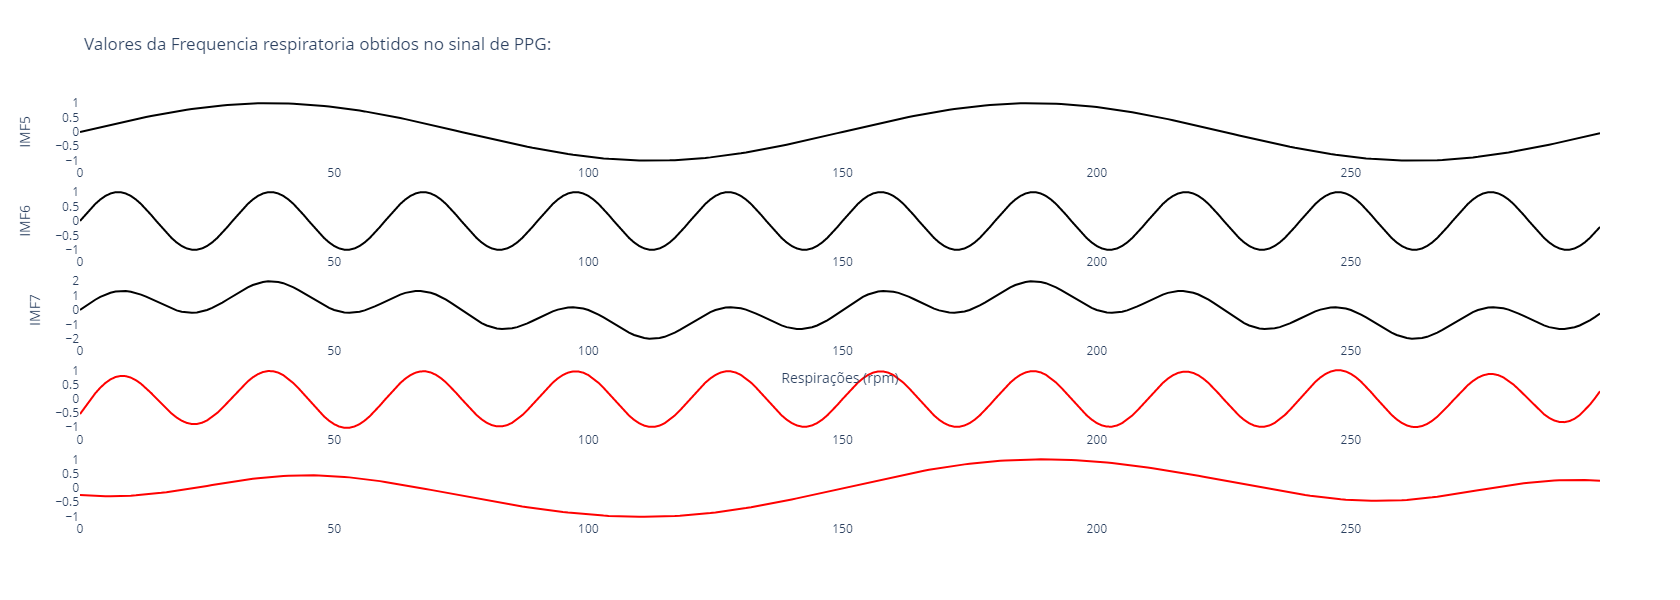

In [371]:
# Create figure
fig = make_subplots(rows=5, cols=1)

    

fig.add_scatter(y=DATA0, name = "(x,y)", marker_color="black",row=1, col=1, showlegend = False)
fig.add_scatter(y=DATA1, name = "(x,y)", marker_color="black",row=2, col=1, showlegend = False)

fig.add_scatter(y=data, name = "(x,y)", marker_color="black",row=3, col=1, showlegend = False)
fig.add_scatter(y=IMF[0], name = "(x,y)", marker_color="RED",row=4, col=1, showlegend = False)
fig.add_scatter(y=IMF[1], name = "(x,y)", marker_color="RED",row=5, col=1, showlegend = False)





# Make 10th trace visible
fig.data[0].visible = True

# Update xaxis properties
fig.update_xaxes(title_text="Respirações (rpm)", row=3, col=1)


# Update yaxis properties
fig.update_yaxes(title_text="IMF5", row=1, col=1)
fig.update_yaxes(title_text="IMF6", row=2, col=1)
fig.update_yaxes(title_text="IMF7", row=3, col=1)


fig.update_layout(
    title="Valores da Frequencia respiratoria obtidos no sinal de PPG:",
    plot_bgcolor='rgba(0,0,0,0)',
    height=600
)

fig.show()

In [252]:
plt.close('all')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
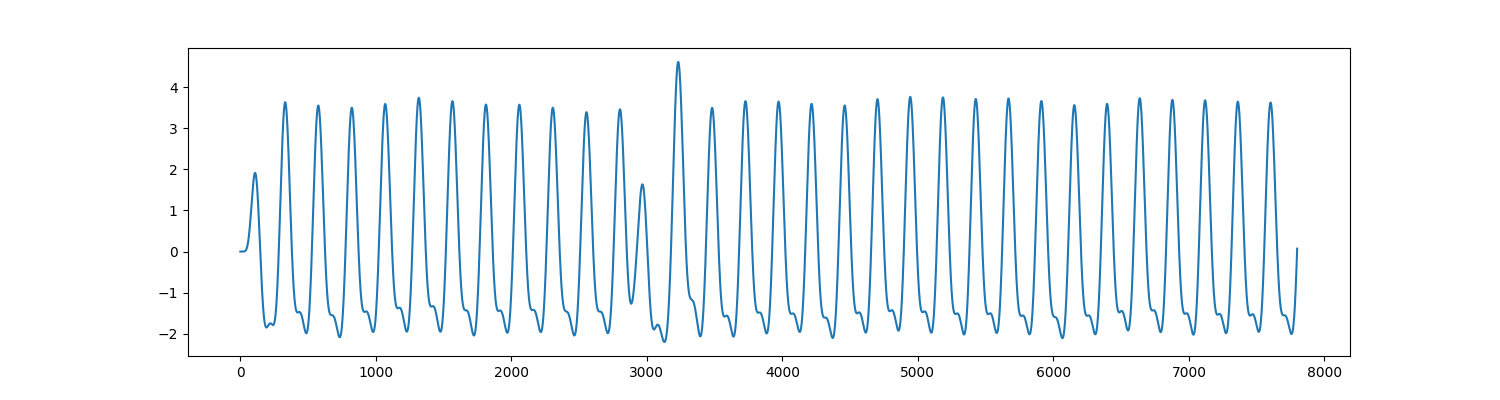

7800

In [140]:
order = 8       
cutoff = 3
data = PPG_cap[34][18000-900:24000+900]
ROGERIN = butter_lowpass_filter(data, cutoff, frequencia, order)

plt.figure(figsize=(15, 4))
plt.plot(ROGERIN)
plt.show()
len(ROGERIN)


46.15384615384615


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
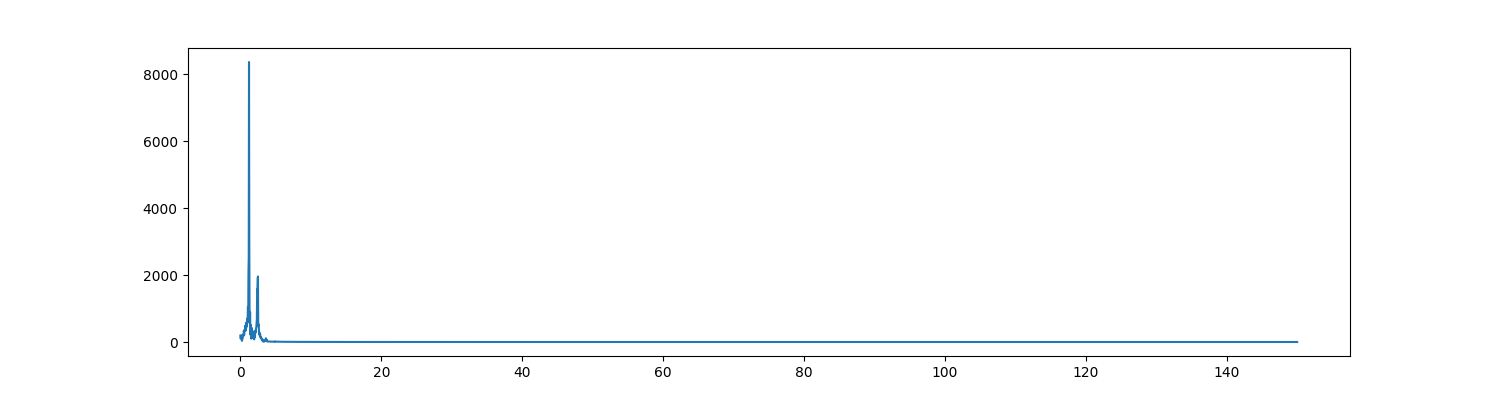

In [476]:
T_PPG = 1/300

y0 = ROGERIN
N_JANELA = len(y0)

yf0 = fft(y0)
xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
yf0 = np.abs(yf0[0:N_JANELA//2])

fy = xf0[5] - xf0[4]
p1 = int(0.15/fy)
p2 = int(0.83/fy)     

pos_y = yf0[p1:p2].argmax()
val_x = xf0[pos_y+p1]
print(val_x*60)

plt.figure(figsize=(15, 4))
plt.plot(xf0,yf0)


plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
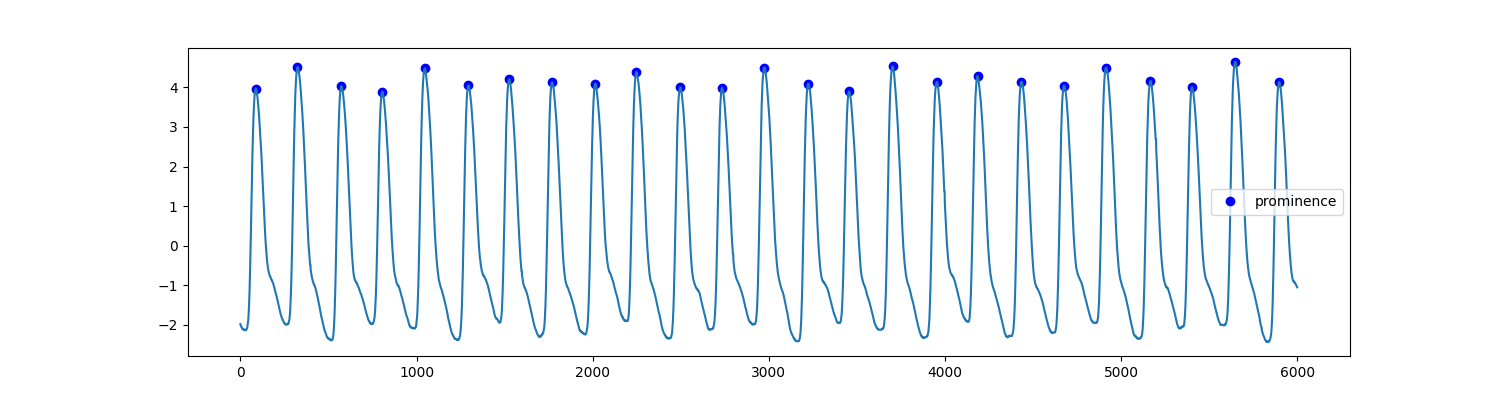

In [66]:
#amplitude
inicio = (60*300)
fim = (80*300)
sinal_original = PPG_cap[39][inicio-1000:fim-1000]
sinal_ac = sinal_original - np.mean(sinal_original)
val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
vales_x, _ = find_peaks((sinal_ac*(-1)), prominence=1)
plt.figure(figsize=(15, 4))
plt.plot(val_x_peaks_ac, sinal_original[val_x_peaks_ac], "ob"); plt.plot(sinal_original); plt.legend(['prominence'])


plt.show()

In [67]:
len(vales_x)

27

In [68]:
len(val_x_peaks_ac)

25

In [547]:
len(sinal_original[val_x_peaks_ac])

21

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
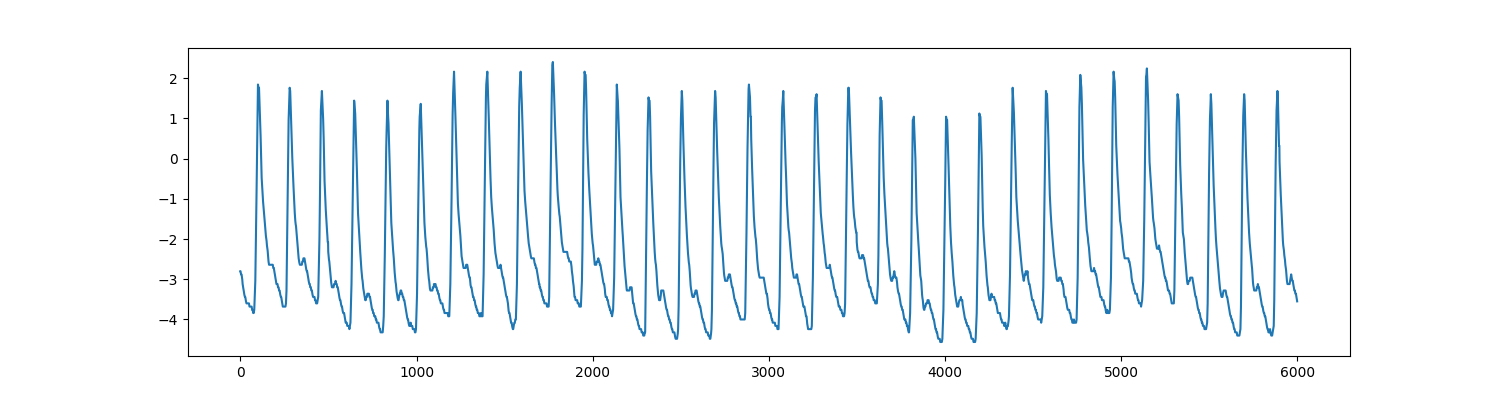

In [421]:
y0 = sinal_original = PPG_cap[18][25500:31500]
plt.figure(figsize=(15, 4))
plt.plot(y0)
plt.show()

In [420]:
%time
for aux_i in range(40):
    print(aux_i)
    www = 0
    for i in range(40):
        #amplitude
        inicio = ((60+i)*300)
        fim = ((80+i)*300)
        sinal_original = PPG_cap[aux_i][inicio-900:fim-900]
        sinal_ac = sinal_original - np.mean(sinal_original)
        val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
        vales_x, _ = find_peaks((sinal_ac*(-1)), prominence=1)

        kleber = np.zeros(len(vales_x)-1)

        for i in range(len(vales_x)-1):              
            kleber[i] = vales_x[i+1] - vales_x[i]
        mediana = np.median(kleber)
        for i in range(len(kleber)):
            if( kleber[i] > (mediana*2) ):
                sinal = "ruim"
            else:
                sinal = "ok"

        if( sinal == "ok"):
            if( abs(len(val_x_peaks_ac) - len(vales_x)) < 3):

                #quantidade de picos menores/igual e primeiro pico começa antes do vale
                if( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
                    pedro = np.zeros(len(val_x_peaks_ac)-1)

                #quantidade de picos menores/igual e primeiro pico começa depois do vale
                elif( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
                    pedro = np.zeros(len(val_x_peaks_ac))

                #quantidade de vales menores/igual e primeiro pico começa antes do vale
                elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
                    pedro = np.zeros(len(vales_x)-1)

                #quantidade de vales menores/igual e primeiro pico começa depois do vale
                elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
                    pedro = np.zeros(len(vales_x))

                else:
                    www = www + 1
                    print("condiçao maluca ver", inicio, fim, www)



                if( val_x_peaks_ac[0] >  vales_x[0]):
                    for z in range(len(pedro)):
                        pedro[z] = sinal_ac[val_x_peaks_ac[z]] - sinal_ac[vales_x[z]]
                else:
                    for z in range(len(pedro)-1):
                        pedro[z] = sinal_ac[val_x_peaks_ac[z+1]] - sinal_ac[vales_x[z]]

                #s_a = interp1d(vales_x[0:len(pedro)], pedro, kind = 'linear',bounds_error = False, fill_value=0.0)
                maria = np.zeros(len(sinal_original))
                for k in range(len(sinal_original)):
                    maria[k] = s_a(k)    
                y0 = maria[900:(len(sinal_original)-900)]
            else:
                www = www + 1
                print("picos e vales diferentes de 3", inicio, fim, www)
        elif( sinal == "ruim"):
            www = www + 1
            print("ruido",inicio, fim, www)
          

#plt.figure(figsize=(15, 4))
#plt.plot(val_x_peaks_ac, sinal_ac[val_x_peaks_ac], "ob"); plt.plot(sinal_ac); plt.legend(['prominence']); plt.plot(vales_x, sinal_ac[vales_x], "or")

#plt.show()

Wall time: 0 ns
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
picos e vales diferentes de 3 25500 31500 1
picos e vales diferentes de 3 25800 31800 2
picos e vales diferentes de 3 26100 32100 3
picos e vales diferentes de 3 26400 32400 4
picos e vales diferentes de 3 26700 32700 5
picos e vales diferentes de 3 27300 33300 6
picos e vales diferentes de 3 27600 33600 7
picos e vales diferentes de 3 27900 33900 8
picos e vales diferentes de 3 28200 34200 9
picos e vales diferentes de 3 28800 34800 10
picos e vales diferentes de 3 29100 35100 11
picos e vales diferentes de 3 29700 35700 12
19
20
21
22
23
24
25
26
27
picos e vales diferentes de 3 18900 24900 1
picos e vales diferentes de 3 19200 25200 2
picos e vales diferentes de 3 19500 25500 3
picos e vales diferentes de 3 19800 25800 4
picos e vales diferentes de 3 21600 27600 5
picos e vales diferentes de 3 21900 27900 6
picos e vales diferentes de 3 22200 28200 7
picos e vales diferentes de 3 22500 28500 8
28
29
30
picos e vales dife

In [416]:
val_x_peaks_ac[30]

4535

21.428571428571427


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
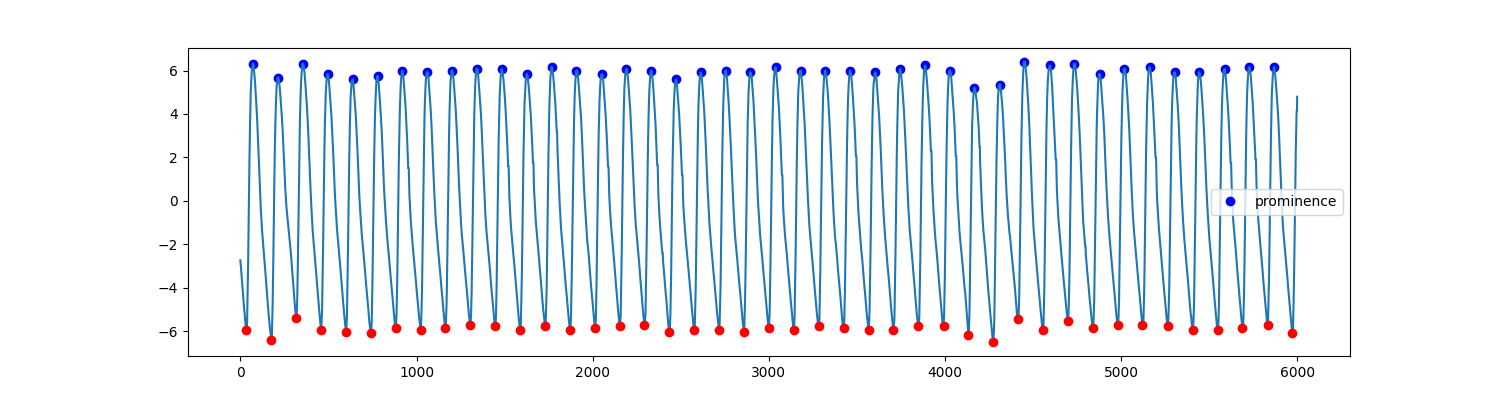

In [509]:
#amplitude


inicio = 75*300
fim = 95*300
sinal_original = PPG_cap[2][inicio-900:fim-900]
sinal_ac = sinal_original - np.mean(sinal_original)
val_x_peaks_ac, _ = find_peaks(sinal_ac, prominence=1)
vales_x, _ = find_peaks((sinal_ac*(-1)), prominence=1)


if( abs(len(val_x_peaks_ac) - len(vales_x)) < 3):

    #quantidade de picos menores/igual e primeiro pico começa antes do vale
    if( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
        pedro = np.zeros(len(val_x_peaks_ac)-1)

    #quantidade de picos menores/igual e primeiro pico começa depois do vale
    elif( (len(val_x_peaks_ac) <= len(vales_x)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
        pedro = np.zeros(len(val_x_peaks_ac))

    #quantidade de vales menores/igual e primeiro pico começa antes do vale
    elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] <  vales_x[0]) ):
        pedro = np.zeros(len(vales_x)-1)

    #quantidade de vales menores/igual e primeiro pico começa depois do vale
    elif( (len(vales_x) <= len(val_x_peaks_ac)) and ( val_x_peaks_ac[0] >  vales_x[0]) ):
        pedro = np.zeros(len(vales_x))

    else:
         print("condiçao maluca ver", inicio, fim)


    if( val_x_peaks_ac[0] >  vales_x[0]):
        for z in range(len(pedro)):
            pedro[z] = sinal_ac[val_x_peaks_ac[z]] - sinal_ac[vales_x[z]]
    else:
        for z in range(len(pedro)):
            pedro[z] = sinal_ac[val_x_peaks_ac[z+1]] - sinal_ac[vales_x[z]]

    s_a = interp1d(vales_x[0:len(pedro)], pedro, kind = 'linear',bounds_error = False, fill_value=0.0)
    maria = np.zeros(len(sinal_original))
    for k in range(len(sinal_original)):
        maria[k] = s_a(k)    
    y0 = maria[900:(len(sinal_original)-900)]


    if(np.std(pedro) > 3.5):
        print("variancia maior q 3,5", inicio, fim)
else:
    print("picos e vales diferentes de 3", inicio, fim)




T_PPG = 1/300

N_JANELA = len(y0)

yf0 = fft(y0)
xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
yf0 = np.abs(yf0[0:N_JANELA//2])

fy = xf0[5] - xf0[4]
p1 = int(0.15/fy)
p2 = int(0.83/fy)     

pos_y = yf0[p1:p2].argmax()
val_x = xf0[pos_y+p1]
print(val_x*60)


plt.figure(figsize=(15, 4))
plt.plot(val_x_peaks_ac, sinal_ac[val_x_peaks_ac], "ob"); plt.plot(sinal_ac); plt.legend(['prominence']); plt.plot(vales_x, sinal_ac[vales_x], "or")

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
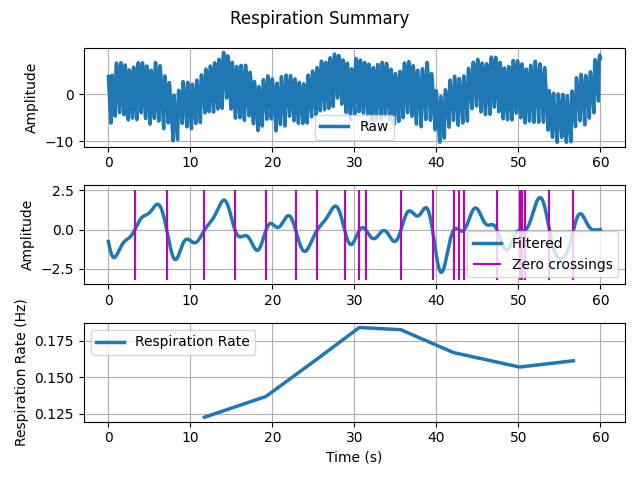

array([0.12270259, 0.13689698, 0.16256685, 0.18410521, 0.18255851,
       0.16691391, 0.1570361 , 0.16133471])

In [536]:
import biosppy as bs
inicio = 60*300
fim = 120*300
s = PPG_cap[10][inicio-900:fim-900]
out = bs.signals.resp.resp(signal=s, sampling_rate=300.0, show=True)
out[4]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
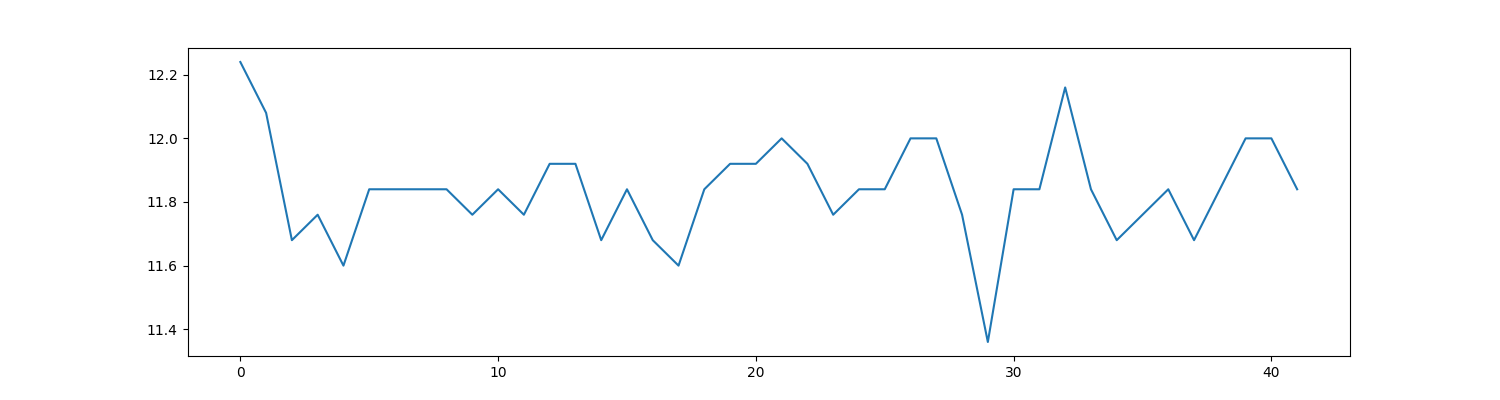

In [512]:
plt.figure(figsize=(15, 4))

plt.plot(pedro)


plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
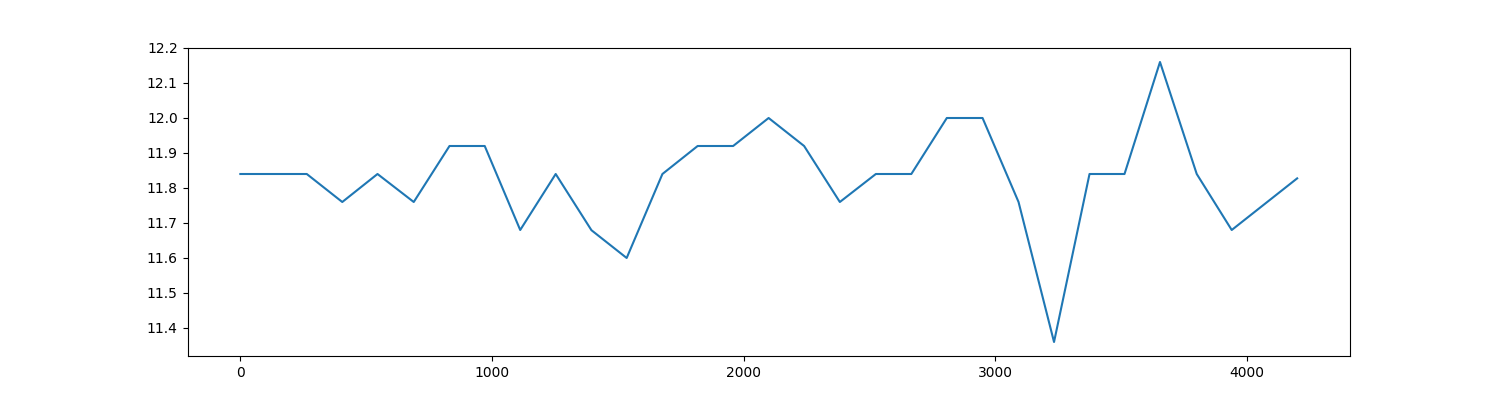

4200

In [513]:
plt.figure(figsize=(15, 4))

plt.plot(y0)


plt.show()
len(y0)

21.428571428571427


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
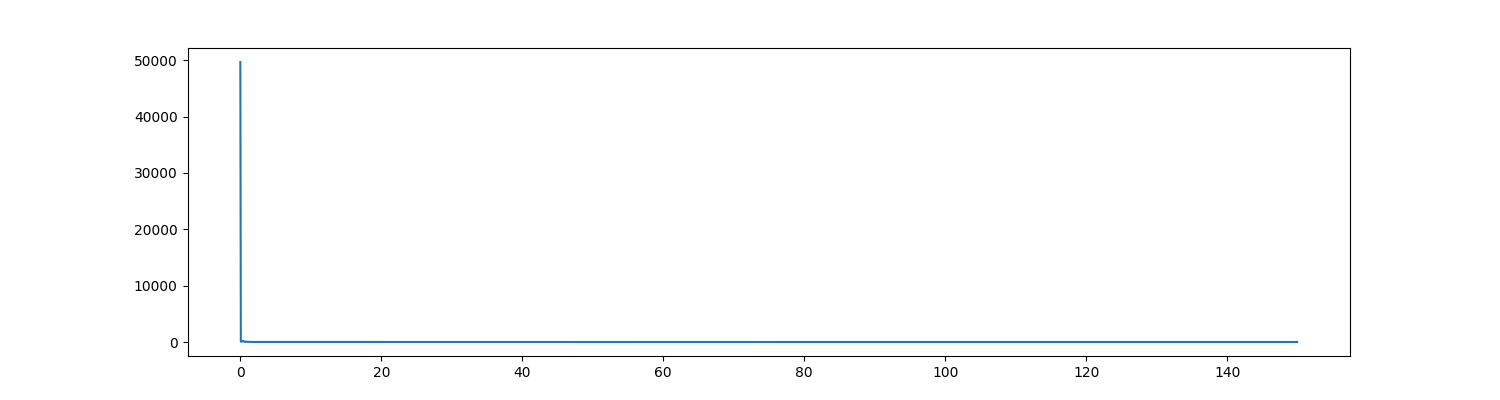

In [514]:
T_PPG = 1/300

N_JANELA = len(y0)

yf0 = fft(y0)
xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
yf0 = np.abs(yf0[0:N_JANELA//2])

fy = xf0[5] - xf0[4]
p1 = int(0.15/fy)
p2 = int(0.83/fy)     

pos_y = yf0[p1:p2].argmax()
val_x = xf0[pos_y+p1]
print(val_x*60)

plt.figure(figsize=(15, 4))
plt.plot(xf0,yf0)


plt.show()

In [22]:
for k in range(40):
    sinal_original = PPG_cap[k][18000:36000]
    tamanho = 300
    teste = np.zeros(17700)
    for i in range(len(teste)):
        teste[i] = np.median(sinal_original[(i):(300+i)])

    T_PPG = 1/300
    N_JANELA = len(teste)

    yf0 = fft(teste)
    xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
    yf0 = np.abs(yf0[0:N_JANELA//2])

    fyy = xf0[5] - xf0[4]
    p1 = int(0.15/fyy)
    p2 = int(0.66/fyy)


    pos_y = yf0[p1:p2].argmax()
    val_x = xf0[pos_y+p1]
    print(k+1,val_x*60)

1 17.288135593220336
2 28.474576271186436
3 10.169491525423727
4 36.61016949152542
5 23.38983050847457
6 12.203389830508472
7 10.169491525423727
8 8.135593220338981
9 10.169491525423727
10 12.203389830508472
11 8.135593220338981
12 17.288135593220336
13 18.30508474576271
14 11.186440677966099
15 10.169491525423727
16 9.152542372881355
17 9.152542372881355
18 9.152542372881355
19 11.186440677966099
20 14.237288135593218
21 17.288135593220336
22 13.220338983050846
23 19.32203389830508
24 14.237288135593218
25 15.25423728813559
26 11.186440677966099
27 10.169491525423727
28 10.169491525423727
29 11.186440677966099
30 18.30508474576271
31 12.203389830508472
32 14.237288135593218
33 10.169491525423727
34 17.288135593220336
35 10.169491525423727
36 10.169491525423727
37 10.169491525423727
38 14.237288135593218
39 13.220338983050846
40 26.440677966101692


40 36.61016949152542


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
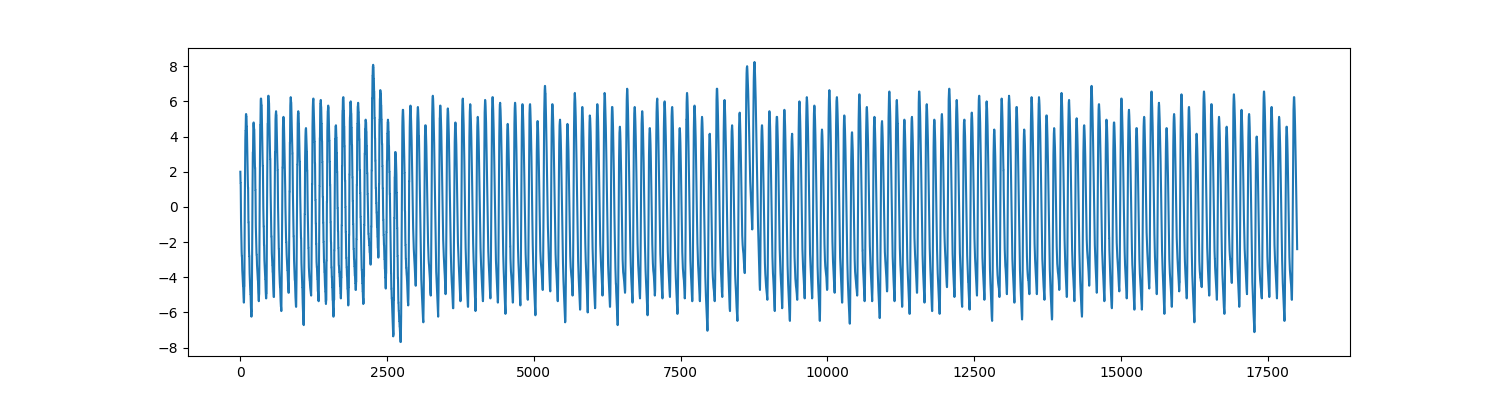

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
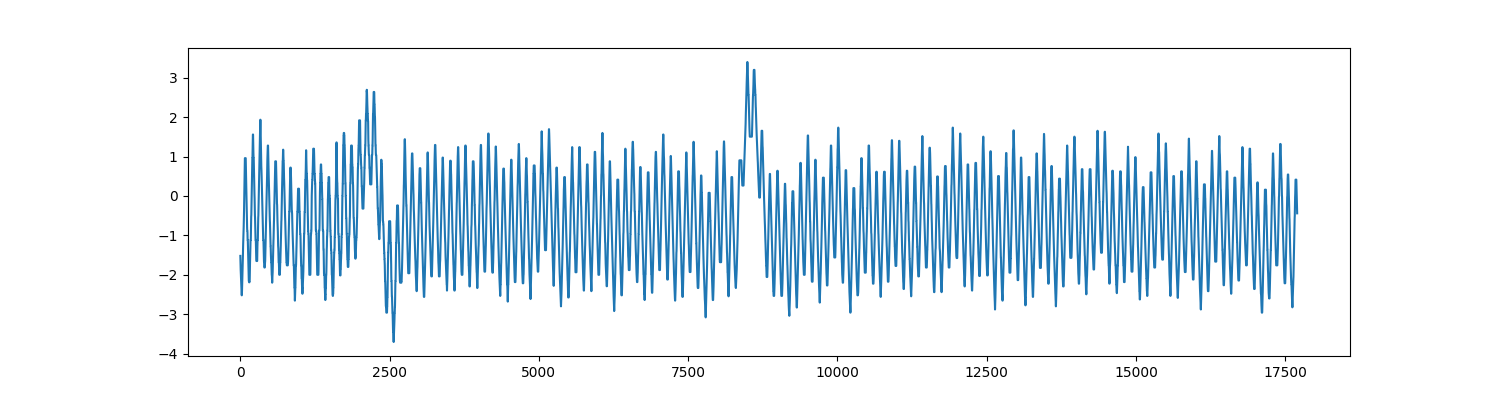

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
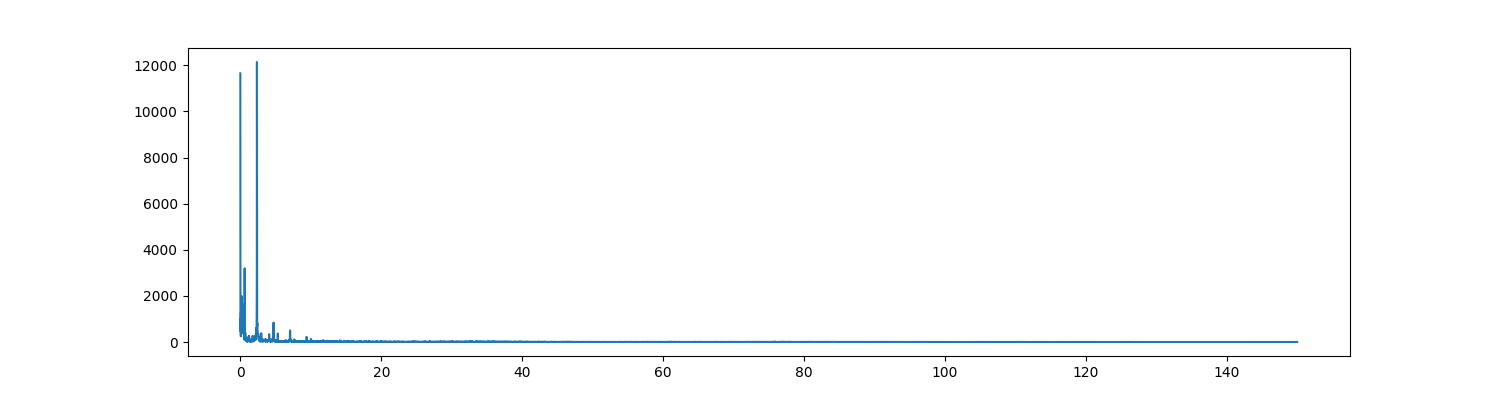

In [31]:
%matplotlib widget
import matplotlib.pyplot as plt 
sinal_original = PPG_cap[3][18000:36000]
tamanho = 300
teste = np.zeros(17700)
for i in range(len(teste)):
    teste[i] = np.median(sinal_original[(i):(300+i)])

T_PPG = 1/300
N_JANELA = len(teste)

yf0 = fft(teste)
xf0 = fftfreq(N_JANELA, T_PPG)[:N_JANELA//2]
yf0 = np.abs(yf0[0:N_JANELA//2])

fyy = xf0[5] - xf0[4]
p1 = int(0.15/fyy)
p2 = int(0.66/fyy)


pos_y = yf0[p1:p2].argmax()
val_x = xf0[pos_y+p1]
print(k+1,val_x*60)
    
plt.figure(figsize=(15, 4))
plt.plot(sinal_original)
plt.show()

plt.figure(figsize=(15, 4))
plt.plot(teste)
plt.show()

plt.figure(figsize=(15, 4))
plt.plot(xf0,yf0)
plt.show()